# Vector Store Details

Ingestion
- Chunk text
- Calculate embedding of each chunk
- Store [chunk,embedding] to vector store, FAISS

Retrieval
- Calculate embedding of query
- semantic search by using the embedding of query as a reference point (kNN)
- Use k Chunks as the augments of the query

Notebook project these embedding vectors to 2D/3D for visualization by using t-SNE, UMAP, and PCA.
It demonstrates the query point, augments of the query, and the rest of the stored embeddings.

## Setup

matplotlib and plotly are for visualization. Plotly supports interactive visualization.


In [ ]:
%pip install langchain
%pip install langchain_core
%pip install langchain_community
%pip -qq install langchainhub
%pip -qq install huggingface-hub
%pip -qq install faiss-cpu
%pip -qq install sentence-transformers
%pip install matplotlib
%pip install plotly

In [ ]:
%pip install --upgrade sentence-transformers

In [5]:
import os
from io import StringIO
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from langchain_community.embeddings import HuggingFaceHubEmbeddings


In [6]:
def get_content(file_name="../data/ThePrince_Machiavelli.txt") -> str:
    data = ""
    with open(file_name, "r",encoding="utf-8") as file:
         data = file.read()
    return data

In [7]:
# test
content = get_content()
content[4000:4250]

' the guidance of Lorenzo de’ Medici, Il Magnifico.\nThe downfall of the Medici in Florence occurred in 1494, in which year\nMachiavelli entered the public service. During his official career\nFlorence was free under the government of a Republic, which l'

In [8]:
def chunk_text(text, chunk_size=1000, chunk_overlap=150):
    text_splitter = RecursiveCharacterTextSplitter(
            separators="\n",
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,  ## linking consecutive chunks
            length_function=len
    )
    chunks = text_splitter.split_text(text)
    return chunks

In [9]:
# test
chunks = chunk_text(content)

In [10]:
print(f"type(chunks)= {type(chunks)}")
print(f"len(chunks) = {len(chunks)}")
start_idx = 40
for i in range(start_idx,start_idx+4):
    print(f"len(chunks[{i}]) = {len(chunks[i])} => [{chunks[i][0:64]} ...]")

type(chunks)= <class 'list'>
len(chunks) = 363
len(chunks[40]) = 980 => [Now I say that those dominions which, when acquired, are added t ...]
len(chunks[41]) = 947 => [only to bear in mind two considerations: the one, that the famil ...]
len(chunks[42]) = 934 => [spot, disorders are seen as they spring up, and one can quickly  ...]
len(chunks[43]) = 960 => [prince does not spend much on colonies, for with little or no ex ...]


Test embedding

In [11]:
from transformers.utils import logging
logging.set_verbosity_error()

In [12]:
from sentence_transformers import SentenceTransformer
def embed_chunks(chunks):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    return model.encode(chunks)

In [13]:
#test
embedded_chunks = embed_chunks(chunks)

In [14]:
print(f"type(embedded_chunks)= {type(embedded_chunks)}")
print(f"len(embedded_chunks) = {len(embedded_chunks)}")
print(f"embedded_chunks.shape = {embedded_chunks.shape}")

type(embedded_chunks)= <class 'numpy.ndarray'>
len(embedded_chunks) = 363
embedded_chunks.shape = (363, 384)


In [15]:
start_idx = 40
for i in range(start_idx,start_idx+4):
    print(f"chunks[{i}] = [{chunks[i][0:32]} ...] => {embedded_chunks[i][0:6]} ...")

chunks[40] = [Now I say that those dominions w ...] => [-0.02507091  0.01606758  0.06972311 -0.11896194 -0.04349811 -0.0283208 ] ...
chunks[41] = [only to bear in mind two conside ...] => [-0.012266    0.05484197  0.01756565 -0.09092116 -0.0095341  -0.02421725] ...
chunks[42] = [spot, disorders are seen as they ...] => [ 0.079357    0.06106947  0.08273438  0.02950769 -0.04516806  0.07001141] ...
chunks[43] = [prince does not spend much on co ...] => [ 0.05889072  0.04274347  0.09256141  0.04474926 -0.0202273   0.01886031] ...


In [16]:
import matplotlib.pyplot as plt
# Visualize the results
def plot_embeddings_2d(X_embedded,y, title='2D t-SNE Projection of Chunk Embeddings'):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter, ticks=[0, 1, 2], label='Class label')
    plt.grid(True)
    plt.show()

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42,perplexity=30) # For 2D visualization
reduced_embeddings2 = tsne.fit_transform(embedded_chunks)

363


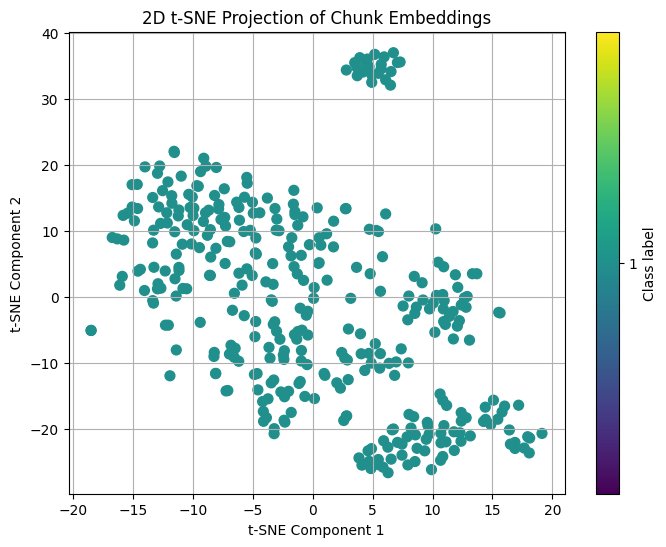

In [18]:
print(len(reduced_embeddings2))
label=[ 1 for i in range(len(reduced_embeddings2))]
plot_embeddings_2d(reduced_embeddings2, label)

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=42,perplexity=30) # For 2D visualization
reduced_embeddings3 = tsne.fit_transform(embedded_chunks)

In [22]:
import plotly.express as px
import pandas as pd

def plot_embeddings_3d(dframe, color_column="label",title='3D t-SNE Projection of Chunk Embeddings'):
    # Visualize the 3D t-SNE projection using Plotly Express
    fig = px.scatter_3d(
        df_tsne,
        x=dframe.columns[0],
        y=dframe.columns[1],
        z=dframe.columns[2],
        color=color_column,
        labels={'color': color_column},
        title=title
    )

    # Customize marker size for better visualization
    fig.update_traces(marker_size=5)

    # Show the plot
    fig.show()

In [32]:
projections = reduced_embeddings3
df_tsne = pd.DataFrame(projections, columns=['TSNE-1', 'TSNE-2', 'TSNE-3'])
df_tsne['label'] = [ 1 for i in range(len(reduced_embeddings3))]
plot_embeddings_3d(df_tsne)

In [ ]:
%pip install umap-learn

In [25]:
from umap import UMAP

def dim_reduction_umap(vectors, dimension=3):
    umap_dr = UMAP(n_components=dimension, init='random', random_state=0)
    return umap_dr.fit_transform(vectors)


In [31]:
projections = dim_reduction_umap(embedded_chunks,dimension=3)
df_tsne = pd.DataFrame(projections, columns=['D-1', 'D-2', 'D-3'])
df_tsne['label'] = [ 1 for i in range(len(projections))]
plot_embeddings_3d(df_tsne,title='3D UMAP Projection of Chunk Embeddings')

C:\Users\timuc\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [28]:
from sklearn.decomposition import PCA

def dim_reduction_pca(vectors, dimension=3):
    pca = PCA(n_components=dimension)
    return pca.fit_transform(vectors)

In [30]:
projections = dim_reduction_pca(embedded_chunks,dimension=3)
df_tsne = pd.DataFrame(projections, columns=['PCA-1', 'PCA-2', 'PCA-3'])
df_tsne['label'] = [ 1 for i in range(len(projections))]
plot_embeddings_3d(df_tsne,title='3D PCA Projection of Chunk Embeddings')

## Store to FAISS Vector Database
Let's add these chunks and embeddings to vector store, FAISS

In [46]:
from langchain_community.vectorstores import FAISS
import numpy as np
import faiss

In [58]:
#
embeddings = embedded_chunks.astype(np.float32)
# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)


Retrieval

In [59]:
# user's question
query="how does prince spend on colonies?"
# Text embedding
query_embedding = embed_chunks(query)
query_embedding = query_embedding.astype(np.float32)
print(f"[{query[0:32]} ...] => {query_embedding[0:6]} ...")

[how does prince spend on colonie ...] => [ 0.07936594  0.03161814  0.02778805  0.01992936 -0.02159635  0.02209677] ...


Query vector store

In [64]:
k = 5  # Number of closest chunks to retrieve
Dist,Idx = index.search(np.array(query_embedding).reshape(1,-1), k)

Let's show the chunk and associated embedding vector

In [70]:
print(Dist[0])
print(Idx[0])
for i in range(0,len(Dist[0])):
    print(f"[{Idx[0][i]} ...] => {Dist[0][i]} ...")

[0.6233611  0.80214566 0.9289033  0.9457941  0.9561129 ]
[ 43  42 221  44  64]
[43 ...] => 0.6233611106872559 ...
[42 ...] => 0.8021456599235535 ...
[221 ...] => 0.9289032816886902 ...
[44 ...] => 0.9457941055297852 ...
[64 ...] => 0.9561129212379456 ...


Building dataframe incrementally, column by column.

In [84]:
df_idx = pd.DataFrame(Idx[0])
df_idx

,0
0,43
1,42
2,221
3,44
4,64


In [85]:
df_dist = pd.DataFrame(Dist[0])
df_dist

,0
0,0.623361
1,0.802146
2,0.928903
3,0.945794
4,0.956113


In [90]:
df_knn =  pd.concat([df_idx, df_dist], axis=1)
df_knn.columns=['Index', 'Distance']
df_knn

,Index,Distance
0,43,0.623361
1,42,0.802146
2,221,0.928903
3,44,0.945794
4,64,0.956113


In [102]:
myLookUp = {}
for idx in df_knn['Index']:
    print(f"[{idx} ...] => ...{chunks[idx][:64]}")
    myLookUp[idx] = chunks[idx]

[43 ...] => ...prince does not spend much on colonies, for with little or no ex
[42 ...] => ...spot, disorders are seen as they spring up, and one can quickly 
[221 ...] => ...Never let any Government imagine that it can choose perfectly sa
[44 ...] => ...ones they cannot; therefore the injury that is to be done to a m
[64 ...] => ...this is not occasioned by the little or abundance of ability in 


In [103]:
df_knn['Chunk'] = df_knn['Index'].apply(lambda x: myLookUp.get(x))
df_knn

,Index,Distance,Chunk
0,43,0.623361,"prince does not spend much on colonies, for wi..."
1,42,0.802146,"spot, disorders are seen as they spring up, an..."
2,221,0.928903,Never let any Government imagine that it can c...
3,44,0.945794,ones they cannot; therefore the injury that is...
4,64,0.956113,this is not occasioned by the little or abunda...


In [105]:
df_knn['Embedding'] =  df_knn['Index'].apply(lambda x: embedded_chunks[x])
df_knn

,Index,Distance,Chunk,Embedding
0,43,0.623361,"prince does not spend much on colonies, for wi...","[0.058890715, 0.04274347, 0.09256141, 0.044749..."
1,42,0.802146,"spot, disorders are seen as they spring up, an...","[0.079357, 0.061069474, 0.08273438, 0.02950769..."
2,221,0.928903,Never let any Government imagine that it can c...,"[0.050540738, 0.10423061, 0.01961176, -0.04452..."
3,44,0.945794,ones they cannot; therefore the injury that is...,"[0.009223385, 0.07131818, 0.052186664, 0.00611..."
4,64,0.956113,this is not occasioned by the little or abunda...,"[0.013173358, 0.102018714, 0.061939694, -0.027..."


Now, each row contains the chunk identifier, distance to query in vector space, chunk content, and corresponding embedding.

In [117]:
import numpy as np
print(f"{embedded_chunks.shape}")
print(f"{query_embedding.shape}")
new_embedded_chunks =  np.vstack([embedded_chunks, query_embedding])
print(f"{new_embedded_chunks.shape}")
print(f"{new_embedded_chunks[-1][0:10]}")
print(f"{query_embedding[0:10]}")


(363, 384)
(384,)
(364, 384)
[ 0.07936594  0.03161814  0.02778805  0.01992936 -0.02159635  0.02209677
  0.07553166 -0.06156521 -0.10973464  0.05012861]
[ 0.07936594  0.03161814  0.02778805  0.01992936 -0.02159635  0.02209677
  0.07553166 -0.06156521 -0.10973464  0.05012861]


Because the vector space has 384 dimensions, it needs to be projected to 2D/3D space for visualization.

In [119]:
new_embedded_chunks =  np.vstack([embedded_chunks, query_embedding])
tsne = TSNE(n_components=3, random_state=42,perplexity=30) # For 2D visualization
reduced_embeddings3q = tsne.fit_transform(new_embedded_chunks)

t-SNE is used for projection.

In [151]:
#
projections = reduced_embeddings3q
df_tsne = pd.DataFrame(projections, columns=['TSNE-1', 'TSNE-2', 'TSNE-3'])
y = [ 1 for i in range(len(reduced_embeddings3q))]
for i in df_knn['Index']:
    y[i]=2
    #print(f"[{i} ...] => y[{i}]={y[i]} ...")
y[-1] = 3
#print(y)
df_tsne['label'] = y
## project query's embedding
plot_embeddings_3d(df_tsne,title='3D t-SNE Projection of Chunk Embeddings; Yellow is query; Purple is kNN, augments')

## Summary
This notebook demonstarted what is happening under the hood to find the pertinent query augments to improve the quality of completion. 